In [1]:
%loadext autoreload
%autoreload 2

UsageError: Line magic function `%loadext` not found.


In [2]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
from jax import numpy as jnp
import jmp # jax mixed-precision
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
shd_dl = spyx.loaders.SHD_loader(256,128,128)

In [7]:
key = jax.random.PRNGKey(0)
x,y = shd_dl.train_epoch(key)

In [53]:
from lif_light import LeakyLinear, RecurrentLIFLight


def lsnn_shd(x, state=None):
    # x = hk.BatchApply(hk.Linear(64))(x)
    print("x_input", x.shape)
    n_rec = 100
    tau = 20
    dt = 1
    core = hk.DeepRNN([
        hk.Linear(n_rec),
        RecurrentLIFLight(n_rec,
            tau=tau,
            thr=0.62,
            dt=dt,
            dtype=jnp.float32,
            dampening_factor=0.3,
            tau_adaptation=500,
            beta=0.07 * jnp.zeros(n_rec),
            tag='',
            stop_gradients=True,
            w_rec_init=None,
            n_refractory=3,
            rec=True,),
       LeakyLinear(n_rec, 20, jnp.exp(-dt/tau))
    ])
    # spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=T)
    # return spikes, V
    # print(x.shape[1])
    # if state is None:
    #     state = core.initial_state(batch_size)
    # spikes, hiddens = core(x, state)#core.initial_state(1)
    spikes, hiddens = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=16) # unroll our model.
    
    return spikes, hiddens

In [54]:
x.shape

(25, 256, 16, 128)

In [55]:
y.shape

(25, 256)

In [56]:
# Create a random key
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
SNN = hk.without_apply_rng(hk.transform(lsnn_shd))
# x0
x0 = jnp.zeros((1, 256, 128))
params = SNN.init(rng=key, x=x0)


x_input (1, 256, 128)
iin (1, 100)
iin (1, 100)


In [57]:
def gd(SNN, params, dl, epochs=300, schedule=3e-4):

    # We use optax for our optimizer.
    opt = optax.lion(learning_rate=schedule)

    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()

    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params

    # define and compile our eval function that computes the loss for our SNN
    # @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return Loss(traces, targets)

    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval)

    rng = jax.random.PRNGKey(0)

    # compile the meat of our training loop for speed
    # @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state = state
        # unpack the data into x, y
        events, targets = data
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient
        loss, grads = surrogate_grad(grad_params, events, targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss

    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    # @jax.jit
    def eval_step(grad_params, data):
        # unpack our data
        events, targets = data
        # decompress information along temporal axis
        events = jnp.unpackbits(events, axis=1)
        # apply the network to the data
        readout = SNN.apply(grad_params, events)
        # unpack the final layer outputs and end state of each SNN layer
        traces, V_f = readout
        # compute accuracy, predictions, and loss
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        # we return the parameters here because of how jax.scan is structured.
        return grad_params, jnp.array([acc, loss])


    val_data = dl.val_epoch()

    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = dl.train_epoch(shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
            train_data.obs.shape[0]# this corresponds to the number of training batches
        )

        new_params, _ = end_state

        # val epoch
        _, val_metrics = jax.lax.scan(
            eval_step,# func
            new_params,# init
            val_data,# xs
            val_data.obs.shape[0]# len
        )


        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), jnp.mean(val_metrics, axis=0)])
    # end epoch

    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state], # metric arrays
        jnp.arange(epochs), #
        epochs # len of loop
    )

    final_params, final_optimizer_state = final_state


    # return our final, optimized network.
    return final_params, metrics

In [60]:
grad_params, metrics = gd(SNN, params, shd_dl, epochs=10) # this takes a minute or two to compile on Colab because of weak CPU compute.


x_input (256, 128, 128)
iin (256, 100)
x_input (256, 128, 128)
iin (256, 100)


  0%|          | 0/10 [00:00<?, ?it/s]

Performance: train_loss=2.5006768703460693, val_acc=0.4427083432674408, val_loss=2.45111083984375


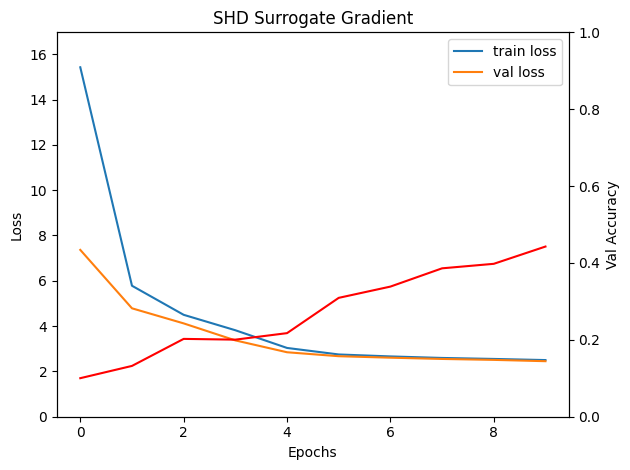

In [66]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*metrics[-1]))

# plt.plot(metrics, label=["train loss", "val acc", "val loss"])
# dual axis
fig, ax1 = plt.subplots()
ax1.plot(metrics[:,0], label="train loss")
ax1.plot(metrics[:,2], label="val loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_ylim(0, max(np.max(metrics[:,0]), np.max(metrics[:,2]))*1.1)
ax2 = ax1.twinx()
ax2.plot(metrics[:,1], label="val acc", color='r')
ax2.set_ylabel("Val Accuracy")
ax2.set_ylim(0,1)
# ax2.legend()




plt.title("SHD Surrogate Gradient")
plt.tight_layout()
plt.show()

In [50]:
def test_gd(SNN, params, dl):

    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()

    # @jax.jit
    def test_step(params, data):
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, events)
        traces, V_f = readout
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        return params, [acc, loss, pred, targets]

    test_data = dl.test_epoch()

    _, test_metrics = jax.lax.scan(
            test_step,# func
            params,# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )

    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts


In [51]:
acc, loss, preds, tgts = test_gd(SNN, grad_params, shd_dl)
print("Accuracy:", acc, "Loss:", loss)


x_input (256, 128, 128)
iin (256, 50)
Accuracy: 0.21484375 Loss: 2.7524304


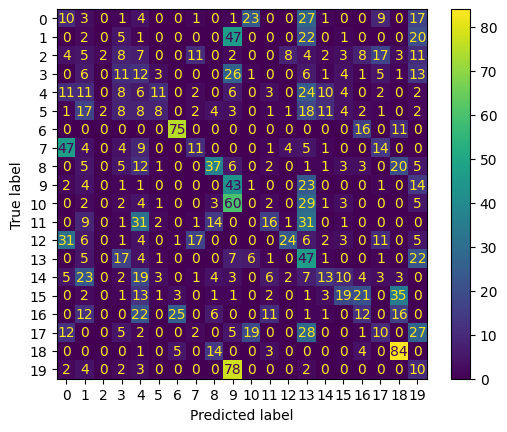

In [52]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()